## Estimating the Effect of a Member Rewards Program
An example on how DoWhy can be used to estimate the effect of a subscription or a rewards program for customers

Suppose that a website has a membership rewards program where customers receive additional benefits if they sign up. How do we know if the program is effective? 

Here the relevant causal question is: > What is the impact of offering the membership rewards program on total sales?

And the equivalent counterfactual question is: > If the current members had not signed up for the program, how much less would they have spent on the website?

In formal language, we are interested in the Average Treatment Effect on the Treated (ATT).

### 1. Formulating the causal model

Suppose that the rewards program was introduced in January 2019. The outcome variable is the total spends at the end of the year. We have data on all monthly transactions of every user and on the time of signup for those who chose to signup for the rewards program. Here's what the data looks like

In [1]:
# Creating some simulated data for our example
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,509,False
1,0,0,2,470,False
2,0,0,3,460,False
3,0,0,4,442,False
4,0,0,5,450,False
...,...,...,...,...,...
119995,9999,8,8,407,True
119996,9999,8,9,533,True
119997,9999,8,10,512,True
119998,9999,8,11,508,True


### The importance of time

Time plays a crucial role in modeling this problem.

Rewards signup can affect the future transaction. but not those that happened before it. In fact, the transactions prior to the reward signup can be assumed to cause the rewards signup decision.  Therefore we split up the variables for each user:

1. Activity prior to the treatment (assumed a cause of the treatment)
2. Activity after the treatment (is the outcome of applying treatment)

Of course, many important variables that affect signup and total spend are missing (e.g., the type of products bought, length of a user's account, geography, etc.). This is a critical assumption in the analysis, one that need to be tested later using refutation test.

Below is the causal graph for a user who signed up in month i=3. The analysis will be similar for any i

In [2]:
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

c:\Users\admin 247\anaconda3\envs\causal-ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\admin 247\AppData\Local\Temp\ipykernel_11736\744467721.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
c:\Users\admin 247\anaconda3\envs\causal-ml\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       489.5   413.111111
1           1             0      False       474.0   434.000000
2           2             0      False       469.5   413.555556
3           3             0      False       492.5   430.000000
4           4             0      False       489.0   417.111111
...       ...           ...        ...         ...          ...
5361     9988             0      False       454.0   417.666667
5362     9991             0      False       469.5   423.777778
5363     9992             0      False       496.0   415.222222
5364     9996             0      False       488.0   417.111111
5365     9998             0      False       485.5   417.333333

[5366 rows x 5 columns]


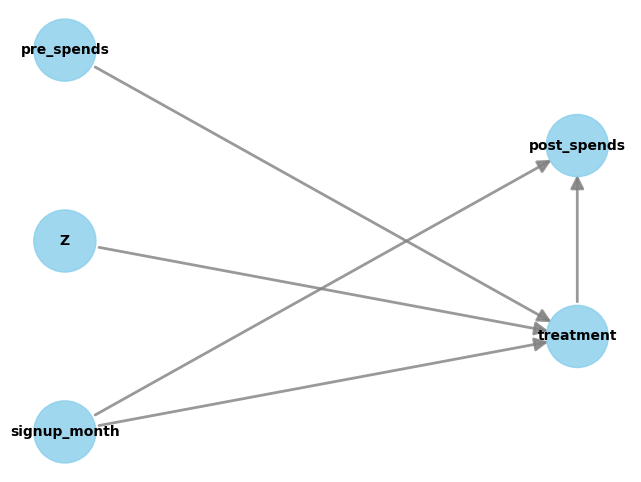

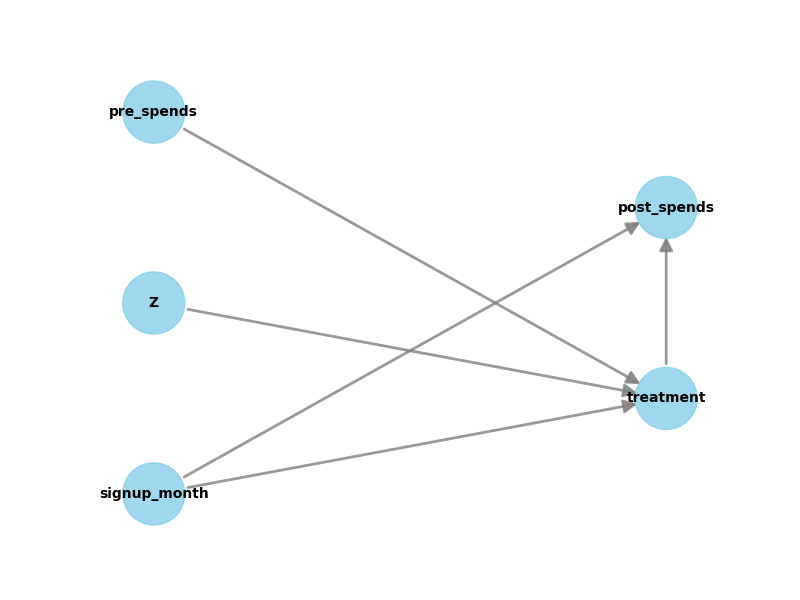

In [3]:
causal_graph = """digraph{
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment-> post_spends;
signup_month->post_spends;
signup_month->treatment;
}
"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

More generally, we an include any activity data for the customer in the above graph. All prior- and post-activity data will occupy the same place (and have the same edges) as the Amount spent node (prior and post respectively)